In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
# Load the Food101 dataset
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQVHD5L/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQVHD5L/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Display information about the dataset
print(ds_info)

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmp6hrjfvpatfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

In [4]:
# Preprocess the data
IMG_SIZE = 224
def preprocess_img(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return tf.cast(image, tf.float32) / 255., label

In [5]:
# Prepare batches
train_batches = train_data.shuffle(buffer_size=1000).map(preprocess_img).batch(32)
test_batches = test_data.map(preprocess_img).batch(32)

In [6]:
# Load pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
# Freeze base model layers
base_model.trainable = False

In [8]:
# Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(101, activation='softmax')

In [9]:
# Build the model
model = tf.keras.Sequential([base_model, global_average_layer, prediction_layer])

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(train_batches, epochs=1, validation_data=test_batches)

2368/2368 [==============================] - 4084s 2s/step - loss: 2.0276 - accuracy: 0.4969 - val_loss: 1.6188 - val_accuracy: 0.5771


In [16]:
# Print training and validation accuracy
print("Training accuracy:", history.history['accuracy'])
print("Validation accuracy:", history.history['val_accuracy'])

Training accuracy: [0.49689769744873047]
Validation accuracy: [0.5771484971046448]


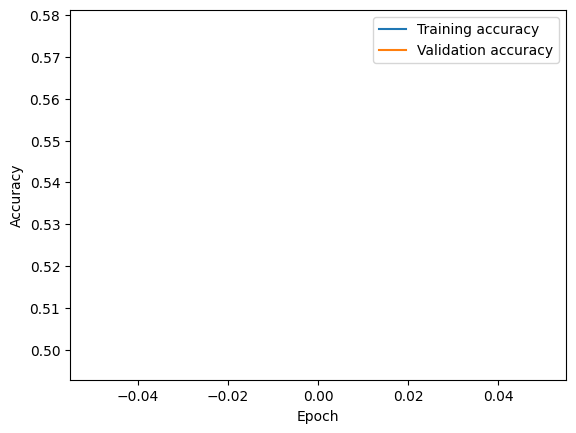

In [17]:
# Get training and validation accuracy values
training_accuracy = history.history.get('accuracy', [0])
validation_accuracy = history.history.get('val_accuracy', [0])

# Plot training and validation accuracy
plt.plot(training_accuracy, label='Training accuracy')
plt.plot(validation_accuracy, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()